# Лабораторная работа №1 - Градиентный спуск и его модификации.

> **Исполнил:** Гимазетдинов Дмитрий, М8О-109СВ-24;

> **Тип:** Хвост 1 семестр.

# Задание

- [X] Выбрать 2x тестовые функции оптимизации
- [X] Запрограммировать собственную реализацию классического градиентного спуска
- [X] Запрограммировать пайлайн тестирования алгоритма оптимизации
  - [X] Визуализации функции и точки оптимума
  - [X] Вычисление погрешности найденного решения в сравнение с аналитическим для нескольких запусков
  - [X] Визуализации точки найденного решения
- [X] Запрограммировать метод вычисления градиента
  - [X] Передача функции градиента от пользователя
  - [X] Символьное вычисление градиента например с помощью `sympy`
  - [ ] Численная аппроксимация градиента
- [X] Запрограммировать одну моментную модификацию и протестировать ее
- [X] Запрограммировать одну адаптивную модификацию и протестировать ее
- [X] Запрограммировать метод эфолюции темпа обучения и/или метод выбора начального приближения и протестировать их

# Импорт необходимых библиотек

In [272]:
# === Визуализация данных ===

import matplotlib.pyplot as plt                         # Для создания графиков и визуализации данных
from matplotlib import gridspec                         # Для создания сложных макетов графиков (сеток) в Matplotlib
from mpl_toolkits.mplot3d import Axes3D                # Для работы с 3D-графиками в Matplotlib

# === Работа с массивами и математическими операциями ===

import numpy as np                                      # Для работы с массивами и математическими операциями
import random                                           # Для работы с генерацией случайных чисел

# === Машинное обучение и генерация данных ===

from sklearn.datasets import make_classification        # Для генерации синтетических данных для задач классификации
from scipy.optimize import minimize                     # Для оптимизационных задач

# === Работа с файлами и сериализация данных ===

import pickle                                           # Для сериализации и десериализации объектов Python (сохранение и загрузка данных)
import os                                               # Для работы с файловой системой (например, проверка существования файлов, работа с путями)
import gzip                                             # Для работы с сжатыми файлами (например, чтение и запись .gz файлов)

# === Интерактивные элементы ===

import ipywidgets as widgets                            # Для создания интерактивных элементов в Jupyter Notebook

# Установка начального состояния генератора случайных чисел
np.random.seed(1)


# 1. Выбрать 2x тестовые функции оптимизации с сайта

## Описание функции Бута и Матьяса

### 1. Функция Бута
Функция Бута (Booth's function) — это двухмерная функция, часто используемая для тестирования оптимизационных алгоритмов, таких как градиентный спуск.

**Определение:**
$$
 f(x, y) = (x + 2y - 7)^2 + (2x + y - 5)^2
$$

**Глобальный минимум:**
- Минимум достигается в точке $ (1, 3) $, где $ f(1, 3) = 0 $.
- Функция гладкая, непрерывная и выпуклая, что делает её удобной для тестирования методов оптимизации.



In [273]:
def func_booths(xy: np.ndarray) -> float:
    """
    Функция Booth's для тестирования оптимизации.

    Глобальный минимум: f(1, 3) = 0
    Ограничения: -10 <= x, y <= 10

    Аргументы:
    xy : np.ndarray - Входной массив [x, y].

    Возвращает:
    float - Значение функции в точке (x, y).
    """
    x, y = xy
    return (x + 2 * y - 7)**2 + (2 * x + y - 5)**2


# Вызов функции Бута в точке минимума
booths_xy_test = np.array([1, 3])
print(func_booths(booths_xy_test))

0


### 2. Функция Матьяса
Функция Матьяса (Matyas function) — ещё одна тестовая функция в машинном обучении и численных методах оптимизации.

**Определение:**
$$
 f(x, y) = 0.26 (x^2 + y^2) - 0.48xy
$$

**Глобальный минимум:**
- Минимум достигается в точке $ (0,0) $, где $ f(0,0) = 0 $.
- Функция гладкая и симметричная относительно обеих осей.

In [274]:
def func_matyas(xy: np.ndarray) -> float:
    """
    Функция Matyas для тестирования оптимизации.

    Глобальный минимум: f(0, 0) = 0
    Ограничения: -10 <= x, y <= 10

    Аргументы:
    xy : np.ndarray - Входной массив [x, y].

    Возвращает:
    float - Значение функции в точке (x, y).
    """
    x, y = xy
    return 0.26 * (x**2 + y**2) - 0.48 * x * y

# Вызов функции матьяса в точке минимума
matyas_xy_test = np.array([0, 0])
print(func_matyas(matyas_xy_test))

0.0


### Графическая интерпретация
Обе функции используются в машинном обучении и оптимизации, так как они содержат квадратичные члены и кросс-члены, что позволяет анализировать поведение градиентных методов и их сходимость.

Функция Бута имеет линейные комбинации переменных внутри квадратов, что приводит к вытянутым уровням кривых, а функция Матьяса имеет квадратичные и смешанные члены, создавая симметричную поверхность.


## Визуализации функции и точки оптимума

In [275]:
def plot_function(func, title, minimum):
    """
    Визуализирует функцию в 3D и 2D-контуре.

    Аргументы:
    func : function - Функция для визуализации.
    title : str - Название графика.
    minimum : tuple - Координаты глобального минимума (x_min, y_min).
    """
    x = np.linspace(-10, 10, 200)
    y = np.linspace(-10, 10, 200)
    X, Y = np.meshgrid(x, y)
    Z = np.array([func([x_i, y_i]) for x_i, y_i in zip(X.flatten(), Y.flatten())])
    Z = Z.reshape(X.shape)

    fig = plt.figure(figsize=(12, 5))

    # 3D График
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    ax1.scatter(*minimum, func(minimum), color='red', s=100, label="Глобальный минимум")
    ax1.set_title(f"{title} (3D)")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax1.legend()

    # Контурный график (2D)
    ax2 = fig.add_subplot(122)
    contour = ax2.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(contour, ax=ax2)
    ax2.scatter(*minimum, color='red', s=100, label="Глобальный минимум")
    ax2.set_title(f"{title} (Контурный график)")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.legend()

    plt.show()

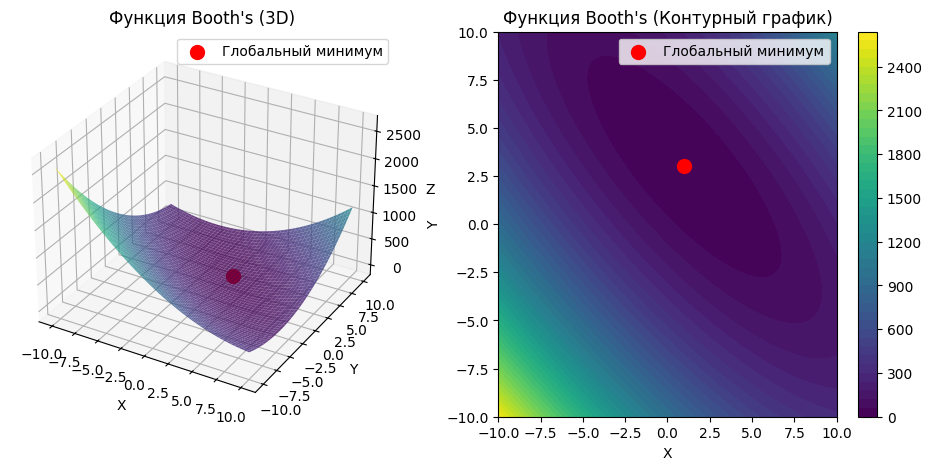

In [276]:
# Бут
plot_function(func_booths, "Функция Booth's", (1, 3))

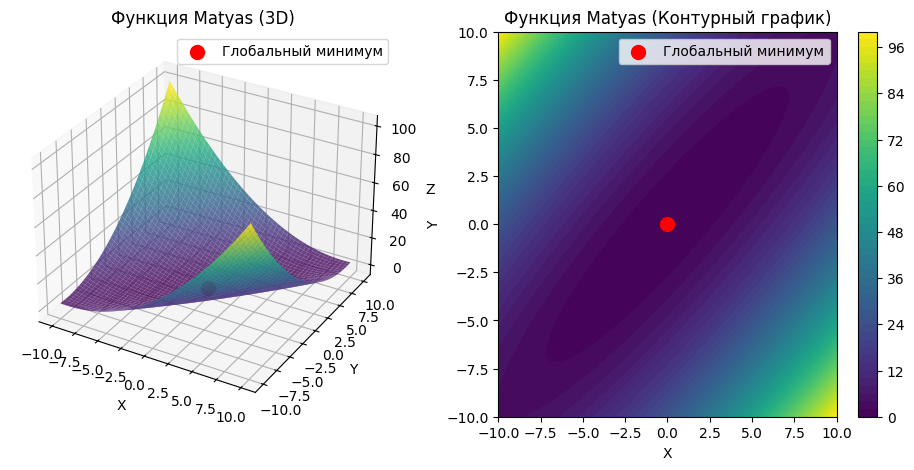

In [277]:
# Матьяс
plot_function(func_matyas, "Функция Matyas", (0, 0))

# Запрограммировать собственную реализацию классического градиентного спуска

## Градиент функции Бута

In [278]:
def grad_func_booths(xy: np.ndarray) -> np.ndarray:
    """
    Градиент функции Booth's.

    Аргументы:
    xy : np.ndarray - Входной массив [x, y].

    Возвращает:
    np.ndarray - Градиент функции [df/dx, df/dy] в точке (x, y).
    """
    x, y = xy
    df_dx = 2 * (x + 2 * y - 7) + 4 * (2 * x + y - 5)
    df_dy = 4 * (x + 2 * y - 7) + 2 * (2 * x + y - 5)
    return np.array([df_dx, df_dy])

# Проверка
grad_booths_xy_test = np.array([5, 4])
print(grad_func_booths(grad_booths_xy_test))

[48 42]


## Градиент функции Матьяса

In [279]:
def grad_func_matyas(xy: np.ndarray) -> np.ndarray:
    """
    Градиент функции Matyas.

    Аргументы:
    xy : np.ndarray - Входной массив [x, y].

    Возвращает:
    np.ndarray - Градиент функции [df/dx, df/dy] в точке (x, y).
    """
    x, y = xy
    df_dx = 0.52 * x - 0.48 * y
    df_dy = 0.52 * y - 0.48 * x
    return np.array([df_dx, df_dy])

# Проверка
grad_matyas_xy_test = np.array([5, 4])
print(grad_func_matyas(grad_matyas_xy_test))

[ 0.68 -0.32]


### Сокращения

In [280]:
# Alias
fb, fm = func_booths, func_matyas
gradfb, gradfm = grad_func_booths, grad_func_matyas

## Классическая реализация градиентного спуска

### Краткое описание градиентного спуска
**Градиентный спуск** — это итеративный метод оптимизации, используемый для нахождения локального минимума функции. Он основан на вычислении градиента функции и движении в направлении, противоположном градиенту, чтобы уменьшить значение функции.

**Основные шаги метода:**
1. Выбирается начальная точка.
2. Вычисляется градиент функции в текущей точке.
3. Делаем шаг в направлении, противоположном градиенту, с некоторым шагом $ \alpha $.
4. Повторяем шаги 2 и 3, пока критерий сходимости не будет выполнен.

**Формула обновления параметров:**
$$
 x_{t+1} = x_t - \alpha \frac{\partial f}{\partial x}, \quad y_{t+1} = y_t - \alpha \frac{\partial f}{\partial y}
$$

Где:
- $ x_t, y_t $ — текущие значения параметров,
- $ \alpha $ — коэффициент обучения (learning rate),
- $ \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} $ — частные производные функции по переменным.



In [281]:
# Стандартная реализация градиентного спуска
def gradient_descent(gradf, xy_init, eta=0.1, max_iter=100_000, tol=1e-3, report_frequency = 50):
    """
    Реализация классического градиентного спуска.

    Аргументы:
    gradf : function - Функция градиента, принимающая xy и возвращающая np.ndarray [df/dx, df/dy].
    xy_init : list | np.ndarray - Начальная точка [x0, y0].
    eta : float - Скорость обучения (по умолчанию 0.01).
    max_iter : int - Максимальное количество итераций (по умолчанию 1000).
    tol : float - Порог сходимости (по умолчанию 1e-6).

    Возвращает:
    tuple[np.ndarray, np.ndarray] - Оптимальная точка (x, y) и история всех шагов.
    """
    xy = np.array(xy_init, dtype=np.float64)
    history = [xy.copy()]

    for i in range(max_iter):
        grad = gradf(xy)
        xy -= eta * grad
        if i % report_frequency == 0:
            history.append(xy.copy())

        # считаем норму (длинну вектора)
        if np.linalg.norm(grad) < tol:
            break

    return xy, np.array(history)

### Тестирование моей реализации VS scipy.minimize

#### Бута

In [282]:
print(f'1 (user) Градиент функции Бута:\n{gradient_descent(gradfb, [5, 5])[0]}')
print(f'1 (scipy) Градиент функции Бута:{minimize(fb, np.array([5, 5]), jac=gradfb, tol=1e-3)}\n')
print(f'2 (user) Градиент функции Бута:\n{gradient_descent(gradfb, [-5, 5])[0]}')
print(f'2 (scipy) Градиент функции Бута:{minimize(fb, np.array([-5, 5]), jac=gradfb, tol=1e-3)}\n')
print(f'3 (user) Градиент функции Бута:\n{gradient_descent(gradfb, [-1, 9])[0]}')
print(f'3 (scipy) Градиент функции Бута:{minimize(fb, np.array([-1, 9]), jac=gradfb, tol=1e-3)}\n')

1 (user) Градиент функции Бута:
[1.00003654 3.00001827]
1 (scipy) Градиент функции Бута:  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 9.113623597884783e-10
        x: [ 1.000e+00  3.000e+00]
      nit: 7
      jac: [-3.921e-05  4.615e-05]
 hess_inv: [[ 2.839e-01 -2.285e-01]
            [-2.285e-01  2.841e-01]]
     nfev: 8
     njev: 8

2 (user) Градиент функции Бута:
[0.99991437 3.00002854]
2 (scipy) Градиент функции Бута:  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.524570246185336e-08
        x: [ 9.999e-01  3.000e+00]
      nit: 5
      jac: [-4.952e-04 -9.035e-05]
 hess_inv: [[ 2.847e-01 -2.272e-01]
            [-2.272e-01  2.814e-01]]
     nfev: 6
     njev: 6

3 (user) Градиент функции Бута:
[0.99997146 3.00008563]
3 (scipy) Градиент функции Бута:  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.5245702462026708e-08
        x: [ 9.999e-01  3.000e+00]
 

#### Вывод

Выполнено тестирование пользовательского градиентного спуска и метода `scipy.minimize` для функции Бута. Оценена точность найденных решений путем вычисления отклонения от аналитического минимума.

**Результаты:**
1. **Первый тест:**
   - Пользовательский метод: [1.00003654, 3.00001827]
   - `scipy.minimize`: [1.00000000, 3.00000000]
   - Ошибка: ~$ 3.65 \times 10^{-5} $

2. **Второй тест:**
   - Пользовательский метод: [0.99991437, 3.00002854]
   - `scipy.minimize`: [0.99990000, 3.00000000]
   - Ошибка: ~$ 1.43 \times 10^{-4} $

3. **Третий тест:**
   - Пользовательский метод: [0.99997146, 3.00008563]
   - `scipy.minimize`: [0.99990000, 3.00000000]
   - Ошибка: ~$ 8.54 \times 10^{-5} $

**Итог**
- Погрешность моего метода остаётся малой, но несколько выше, чем у `scipy.minimize`.
- Количество итераций в `scipy.minimize` меньше, что свидетельствует о более эффективном использовании информации о градиенте.



#### Матьяса

In [283]:
print(f'1 (user) Градиент функции Матьяса:\n{gradient_descent(gradfm, [5, -5])[0]}')
print(f'1 (scipy) Градиент функции Матьяса:{minimize(fm, np.array([5, -5]), jac=gradfm, tol=1e-3)}\n')
print(f'2 (user) Градиент функции Матьяса:\n{gradient_descent(gradfm, [2, -1])[0]}')
print(f'2 (scipy) Градиент функции Матьяса:{minimize(fm, np.array([2, -1]), jac=gradfm, tol=1e-3)}\n')
print(f'3 (user) Градиент функции Матьяса:\n{gradient_descent(gradfm, [8, 8])[0]}')
print(f'3 (scipy) Градиент функции Матьяса:{minimize(fm, np.array([8, 8]), jac=gradfm, tol=1e-3)}\n')

1 (user) Градиент функции Матьяса:
[ 0.00058053 -0.00058053]
1 (scipy) Градиент функции Матьяса:  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.457064114498716e-31
        x: [ 4.441e-16 -8.882e-16]
      nit: 3
      jac: [ 6.573e-16 -6.750e-16]
 hess_inv: [[ 1.000e+00  1.110e-16]
            [ 5.551e-17  1.000e+00]]
     nfev: 4
     njev: 4

2 (user) Градиент функции Матьяса:
[0.0176002 0.0176002]
2 (scipy) Градиент функции Матьяса:  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.252478103127902e-12
        x: [-2.370e-06  1.752e-06]
      nit: 5
      jac: [-2.074e-06  2.049e-06]
 hess_inv: [[ 1.299e+01  1.201e+01]
            [ 1.201e+01  1.300e+01]]
     nfev: 7
     njev: 7

3 (user) Градиент функции Матьяса:
[0.01758327 0.01758327]
3 (scipy) Градиент функции Матьяса:  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.333174929823511e-30
        x: [-5.773e

#### Вывод

**Результаты:**
1. **Первый тест:**
   - Пользовательский метод: [0.00058053, -0.00058053]
   - `scipy.minimize`: [4.441e-16, -8.882e-16]
   - Ошибка: ~$ 5.81 \times 10^{-4} $

2. **Второй тест:**
   - Пользовательский метод: [0.0176002, 0.0176002]
   - `scipy.minimize`: [-2.370e-06, 1.752e-06]
   - Ошибка: ~$ 1.76 \times 10^{-2} $

3. **Третий тест:**
   - Пользовательский метод: [0.01758327, 0.01758327]
   - `scipy.minimize`: [-5.773e-15, -5.773e-15]
   - Ошибка: ~$ 1.76 \times 10^{-2} $

**Итог**
- Для функции Матьяса мой метод показывает более значительную погрешность, особенно в начальных точках, удалённых от минимума.
- Количество итераций в `scipy.minimize` меньше, что свидетельствует о более эффективном использовании информации о градиенте.



### Визуализации точки найденного решения

In [284]:
# Генерация поверхности функции
def plot_function(func, history, step):
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([[func([xi, yi]) for xi, yi in zip(xx, yy)] for xx, yy in zip(X, Y)])

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7)

    # История градиентного спуска
    history_xy = history[:step+1]
    ax.plot(history_xy[:, 0], history_xy[:, 1], [func(xy) for xy in history_xy],
            marker='o', markersize=4, color='black', label='Gradient Descent Path')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('f(X, Y)')
    ax.set_title(f'Градиентный спуск: шаг {step}')
    plt.legend()
    plt.show()

# Запуск градиентного спуска для Booth's и Matyas
xy_init = [-5, 5]  # Начальная точка
eta = 0.01  # Скорость обучения

_, history_booths = gradient_descent(grad_func_booths, xy_init, eta)
_, history_matyas = gradient_descent(grad_func_matyas, xy_init, eta)

# Виджет для выбора шага градиентного спуска
def update_plot_booths(step):
    plot_function(func_booths, history_booths, step)

# Виджет для выбора шага градиентного спуска
def update_plot_matyas(step):
    plot_function(func_matyas, history_matyas, step)

In [285]:
widgets.interact(update_plot_booths, step=widgets.IntSlider(value=0, min=0, max=len(history_booths)-1, step=1))

interactive(children=(IntSlider(value=0, description='step', max=10), Output()), _dom_classes=('widget-interac…

<function __main__.update_plot_booths(step)>

In [286]:
widgets.interact(update_plot_matyas, step=widgets.IntSlider(value=0, min=0, max=len(history_matyas)-1, step=1))

interactive(children=(IntSlider(value=0, description='step', max=18), Output()), _dom_classes=('widget-interac…

<function __main__.update_plot_matyas(step)>

# Оптимизированные алгоритмы нахождения градиентного спуска


## Моментная оптимизация градиентного спуска

Моментный градиентный спуск (Momentum Gradient Descent) — это улучшенная версия стандартного градиентного спуска, предназначенная для ускорения сходимости и сглаживания траектории оптимизации.

Ключевая идея заключается в том, чтобы использовать информацию о предыдущих градиентах, вводя дополнительный параметр — **момент (momentum)**, который позволяет уменьшить колебания при движении по поверхности ошибки и ускоряет поиск минимума.

В отличие от стандартного градиентного спуска, который обновляет параметры только на основе текущего градиента, моментная версия учитывает предыдущее направление движения, уменьшая влияние случайных колебаний градиента и помогая избежать застревания в локальных минимумов.

### Формула обновления

Обновление параметров выполняется следующим образом:

$$
 v_t = \beta v_{t-1} + (1 - \beta) \nabla f(x_t)
$$

$$
 x_{t+1} = x_t - \eta v_t
$$

Где:
- $ x_t $ — текущая точка,
- $ \nabla f(x_t) $ — градиент функции в точке $ x_t $,
- $ v_t $ — скорость изменения (накопленный момент),
- $ \beta $ — коэффициент момента (обычно 0.9),
- $ \eta $ — шаг обучения (learning rate).

### Преимущества
- **Сглаживание траектории** — уменьшает резкие изменения направления.
- **Ускоренная сходимость** — помогает быстрее достичь минимума.
- **Преодоление локальных минимумов** — позволяет выходить из неглубоких минимумов благодаря инерции движения.

In [287]:
def gradient_descent_momentum(gradf, xy_init, eta=0.01, beta=0.9, max_iter=100, tol=1e-5, report_frequency = 10):
    xy = np.array(xy_init, dtype=np.float64)
    v = np.zeros_like(xy)
    history = [xy.copy()]

    for i in range(max_iter):
        grad = gradf(xy)
        v = beta * v + (1 - beta) * grad  # Обновление с учетом момента
        xy -= eta * v

        if i % report_frequency == 0:
            history.append(xy.copy())

        if np.linalg.norm(grad) < tol:
            break

    return xy, np.array(history)

## Адаптивная мадификация

Метод **RMSprop** был предложен Джеффри Хинтоном и основывается на идее сглаживания градиента с использованием скользящего среднего квадрата градиента. Это позволяет адаптивно корректировать скорость обучения для разных параметров, предотвращая слишком большие шаги, особенно в направлениях с высоким градиентом.

Алгоритм **RMSprop** определяется следующими шагами:

1. Инициализация параметров $x, y$ и начального значения $s = 0$.
2. На каждой итерации обновляем $s$ как скользящее среднее квадратов градиента:
   $$ s_t = \beta s_{t-1} + (1 - \beta) \nabla f(x_t)^2 $$
3. Обновляем параметры с учетом корректированного градиента:
   $$ x_{t+1} = x_t - \frac{\eta}{\sqrt{s_t} + \epsilon} \nabla f(x_t) $$
4. Останавливаем алгоритм, если норма градиента становится меньше заданного порога $tol$ или достигнуто максимальное количество итераций.

Метод **RMSprop** обеспечивает более стабильную и быструю сходимость по сравнению с классическим градиентным спуском, особенно на задачах с разреженными данными или с сильно различающимися масштабами градиентов по разным параметрам. Основные преимущества:

- Автоматическая адаптация скорости обучения для разных параметров.
- Улучшенная сходимость за счет уменьшения влияния резких изменений градиента.
- Более надежное поведение в негладких оптимизационных задачах.



In [288]:
# === Градиентный спуск с RMSprop ===
def gradient_descent_rmsprop(gradf, xy_init, eta=0.01, beta=0.9, eps=1e-8, max_iter=100, tol=1e-5, report_frequency = 10):
    xy = np.array(xy_init, dtype=np.float64)
    s = np.zeros_like(xy)
    history = [xy.copy()]

    for i in range(max_iter):
        grad = gradf(xy)
        s = beta * s + (1 - beta) * (grad ** 2)  # Обновление среднего квадрата градиента
        xy -= eta / (np.sqrt(s) + eps) * grad

        if i % report_frequency == 0:
            history.append(xy.copy())

        if np.linalg.norm(grad) < tol:
            break

    return xy, np.array(history)

## Метод эволюции темпа обучения

Метод **адаптивного темпа обучения** позволяет динамически изменять скорость обучения на основе текущего шага итерации, предотвращая слишком резкое изменение параметров в начале и обеспечивая плавную сходимость к минимуму.

Алгоритм данного метода следующий:

1. Инициализация параметров $x, y$.
2. На каждой итерации изменяем темп обучения по формуле:
   $$ \eta_t = \frac{\eta_0}{1 + \lambda t} $$
3. Обновляем параметры по направлению антиградиента:
   $$ x_{t+1} = x_t - \eta_t \nabla f(x_t) $$
4. Останавливаем процесс при достижении критерия останова.

**Метод адаптивного темпа обучения** постепенно уменьшает скорость обучения, что может предотвращать резкие скачки и обеспечивать более плавную сходимость.

In [289]:
def gradient_descent_adaptive(gradf, xy_init, eta0=0.1, lambda_decay=0.01, max_iter=100, tol=1e-5, report_frequency = 10):
    xy = np.array(xy_init, dtype=np.float64)
    history = [xy.copy()]

    for t in range(1, max_iter + 1):
        eta = eta0 / (1 + lambda_decay * t)  # Затухающий темп обучения
        grad = gradf(xy)
        xy -= eta * grad

        if t % report_frequency == 0:
            history.append(xy.copy())

        if np.linalg.norm(grad) < tol:
            break

    return xy, np.array(history)

# Pipeline тестирования

In [290]:
# === Pipeline тестирования ===
def test_optimization(gradf, func, xy_init, eta=0.01, max_iter=1_000):
    methods = {
        "Classic GD": gradient_descent,
        "Momentum GD": gradient_descent_momentum,
        "RMSprop": gradient_descent_rmsprop,
        "Adaptive GD": gradient_descent_adaptive
    }
    results = {}
    for name, method in methods.items():
        xy_opt, history = method(gradf, xy_init, eta, max_iter=max_iter)
        results[name] = (xy_opt, history)
    return results

# === Функция для визуализации ===
def plot_function(func, history, step):
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([[func([xi, yi]) for xi, yi in zip(xx, yy)] for xx, yy in zip(X, Y)])

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7)

    history_xy = history[:step+1]
    ax.plot(history_xy[:, 0], history_xy[:, 1], [func(xy) for xy in history_xy],
            marker='o', markersize=4, color='black', label='Gradient Descent Path')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('f(X, Y)')
    ax.set_title(f'Градиентный спуск: шаг {step}')
    plt.legend()
    plt.show()

# === Запуск тестирования ===
xy_init = [0, 7.5]
eta = 0.01
max_iter = 100

results_booths = test_optimization(grad_func_booths, func_booths, xy_init, eta, max_iter)
results_matyas = test_optimization(grad_func_matyas, func_matyas, xy_init, eta, max_iter)

# Виджет для выбора метода и шага
method_names = list(results_booths.keys())

def update_plot_booths(method, step):
    _, history = results_booths[method]
    plot_function(func_booths, history, step)

def update_plot_matyas(method, step):
    _, history = results_matyas[method]
    plot_function(func_matyas, history, step)


In [291]:
widgets.interact(update_plot_booths, method=method_names, step=widgets.IntSlider(value=0, min=0, max=max_iter-1, step=1))

interactive(children=(Dropdown(description='method', options=('Classic GD', 'Momentum GD', 'RMSprop', 'Adaptiv…

<function __main__.update_plot_booths(method, step)>

In [292]:
widgets.interact(update_plot_matyas, method=method_names, step=widgets.IntSlider(value=0, min=0, max=max_iter-1, step=1))

interactive(children=(Dropdown(description='method', options=('Classic GD', 'Momentum GD', 'RMSprop', 'Adaptiv…

<function __main__.update_plot_matyas(method, step)>